# Sentiment Analysis on Amazon Reviews dataset 2023

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from Huggingface
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [3]:
# Read in data
Appliance_subset_df = pd.read_parquet('..\Project Main\data\Appliance_file_subset.parquet', engine='pyarrow')

In [4]:
Appliance_subset_df.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,2.0,"Maybe they be ok for you, but",It was difficult for this old guy to get down ...,[],B074FP8GC5,B0BWXQJ5XT,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,1619039933066,0,True
1,5.0,Five Stars,Great!,[],B0000CF3HB,B0000CF3HB,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,1485195813000,0,True
2,5.0,Saves a lot on the cost of coffee.,Works very well. They also clean very easily.,[],B01AUBYMK2,B07RNJY499,AGIOHNK7IWRDNBWYPGETIDTKTJUA,1505914496902,0,True
3,5.0,Works great,Easy to use. Easy to remove. Works as it sho...,[],B079ZJ1H3P,B06XXPGQQV,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,1605903535168,0,True
4,5.0,Humidifier Filters,As described great shape thank you,[],B000E1385Y,B000E1385Y,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,1645229528359,0,True


In [5]:
print(Appliance_subset_df.shape)

(50000, 10)


In [6]:
Appliance_subset_df['rating'].value_counts().sort_index()

rating
1.0     5918
2.0     1871
3.0     2421
4.0     5024
5.0    34766
Name: count, dtype: int64

## Quick EDA

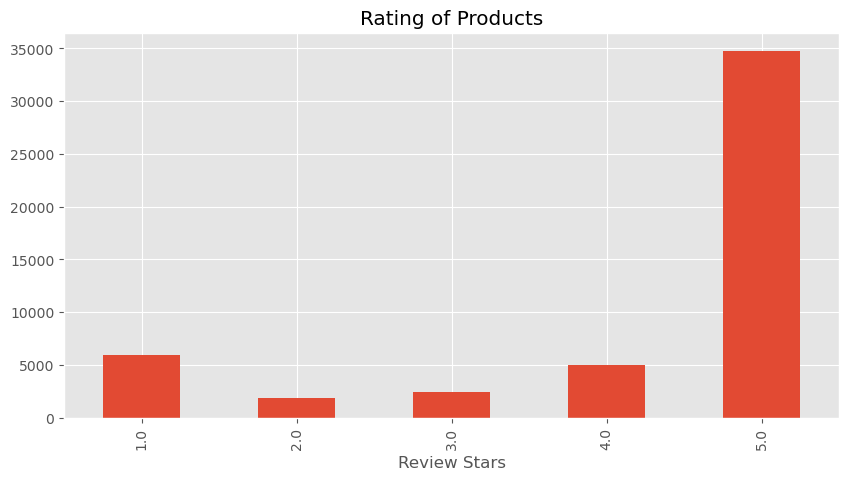

In [7]:
rating = Appliance_subset_df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Rating of Products',
          figsize=(10, 5))
rating.set_xlabel('Review Stars')
plt.show()

## NLTK

In [8]:
example = Appliance_subset_df['text'][1989]
print(example)

Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...


In [9]:
tokens = nltk.word_tokenize(example)
tokens[:]

['Easy',
 'Replacement',
 'Parts',
 'for',
 'Appliances',
 'at',
 'a',
 'Reduced',
 'Price',
 'and',
 'fits',
 'perfect',
 '...']

In [10]:
#part of speech tagging values
tagged = nltk.pos_tag(tokens)
tagged[:]

[('Easy', 'JJ'),
 ('Replacement', 'NNP'),
 ('Parts', 'NNP'),
 ('for', 'IN'),
 ('Appliances', 'NNP'),
 ('at', 'IN'),
 ('a', 'DT'),
 ('Reduced', 'NNP'),
 ('Price', 'NNP'),
 ('and', 'CC'),
 ('fits', 'NNS'),
 ('perfect', 'VBP'),
 ('...', ':')]

In [11]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()
#prettyprint

(S
  (PERSON Easy/JJ)
  (ORGANIZATION Replacement/NNP Parts/NNP)
  for/IN
  Appliances/NNP
  at/IN
  a/DT
  (ORGANIZATION Reduced/NNP)
  Price/NNP
  and/CC
  fits/NNS
  perfect/VBP
  .../:)


# Step 1. VADER Sentiment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [13]:
sia

In [14]:
sia.polarity_scores("It was a complete waste of time")

{'neg': 0.359, 'neu': 0.641, 'pos': 0.0, 'compound': -0.4215}

In [15]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

In [16]:
sia.polarity_scores("Fits perfect")

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

In [17]:
sia.polarity_scores('Easy Replacement Parts for Appliances at a Reduced Price and fits perfect')

{'neg': 0.0, 'neu': 0.577, 'pos': 0.423, 'compound': 0.765}

In [18]:
sia.polarity_scores('Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...')

{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

In [19]:
# Run the polarity score on the entire dataset
results = {}
for i, row in tqdm(Appliance_subset_df.iterrows(), total=len(Appliance_subset_df)):
    opinion = row['text']
    id = row['user_id']
    results[id] = sia.polarity_scores(opinion)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [20]:
results

{'AFJBSFUSBCMWLLXMBZ44ETHRKNOA': {'neg': 0.072,
  'neu': 0.809,
  'pos': 0.118,
  'compound': 0.3818},
 'AGB653QU2TLQPUZ2QX3VNRWFOUKQ': {'neg': 0.0,
  'neu': 0.0,
  'pos': 1.0,
  'compound': 0.6588},
 'AGIOHNK7IWRDNBWYPGETIDTKTJUA': {'neg': 0.0,
  'neu': 0.391,
  'pos': 0.609,
  'compound': 0.7774},
 'AGBTZVKIXMEBARPSYPIQLFH2NYWQ': {'neg': 0.0,
  'neu': 0.58,
  'pos': 0.42,
  'compound': 0.7003},
 'AHKS2IQWTIFWQZTUVP23U2GYLO5Q': {'neg': 0.0,
  'neu': 0.377,
  'pos': 0.623,
  'compound': 0.765},
 'AHY557OHZXZUGKRAB6ZHRONRE26A': {'neg': 0.0,
  'neu': 0.671,
  'pos': 0.329,
  'compound': 0.6597},
 'AGOICXX54S3SREXAOM3BYYN4AZRA': {'neg': 0.082,
  'neu': 0.918,
  'pos': 0.0,
  'compound': -0.395},
 'AHO74DWEGRT3UVGRKG4CCOMTL5BA': {'neg': 0.0,
  'neu': 0.734,
  'pos': 0.266,
  'compound': 0.4404},
 'AH7AGJZSWT5KAEW4OFJIH5DQCUUA': {'neg': 0.042,
  'neu': 0.863,
  'pos': 0.096,
  'compound': 0.9699},
 'AFMZ3YXI2VANHHEXF2LCBCYHFEGA': {'neg': 0.043,
  'neu': 0.803,
  'pos': 0.154,
  'compound': 

In [21]:
vaders = pd.DataFrame(results).T
vaders.head()

,neg,neu,pos,compound
AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [22]:
vaders.index.name = 'user_id'
vaders.head()

,neg,neu,pos,compound
user_id,,,,
AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [23]:
# Reset the index to turn the index into a column
vaders = vaders.reset_index()
vaders.head()


,user_id,neg,neu,pos,compound
0,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818
1,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588
2,AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774
3,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003
4,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650


In [24]:
vaders = vaders.merge(Appliance_subset_df, how='inner')

In [25]:
# Now we have sentiment score and metadata
vaders.head()

,user_id,neg,neu,pos,compound,rating,title,text,images,asin,parent_asin,timestamp,helpful_vote,verified_purchase
0,AFJBSFUSBCMWLLXMBZ44ETHRKNOA,0.072,0.809,0.118,0.3818,2.0,"Maybe they be ok for you, but",It was difficult for this old guy to get down ...,[],B074FP8GC5,B0BWXQJ5XT,1619039933066,0,True
1,AGB653QU2TLQPUZ2QX3VNRWFOUKQ,0.000,0.000,1.000,0.6588,5.0,Five Stars,Great!,[],B0000CF3HB,B0000CF3HB,1485195813000,0,True
2,AGIOHNK7IWRDNBWYPGETIDTKTJUA,0.000,0.391,0.609,0.7774,5.0,Saves a lot on the cost of coffee.,Works very well. They also clean very easily.,[],B01AUBYMK2,B07RNJY499,1505914496902,0,True
3,AGBTZVKIXMEBARPSYPIQLFH2NYWQ,0.000,0.580,0.420,0.7003,5.0,Works great,Easy to use. Easy to remove. Works as it sho...,[],B079ZJ1H3P,B06XXPGQQV,1605903535168,0,True
4,AHKS2IQWTIFWQZTUVP23U2GYLO5Q,0.000,0.377,0.623,0.7650,5.0,Humidifier Filters,As described great shape thank you,[],B000E1385Y,B000E1385Y,1645229528359,0,True


## Plot VADER results

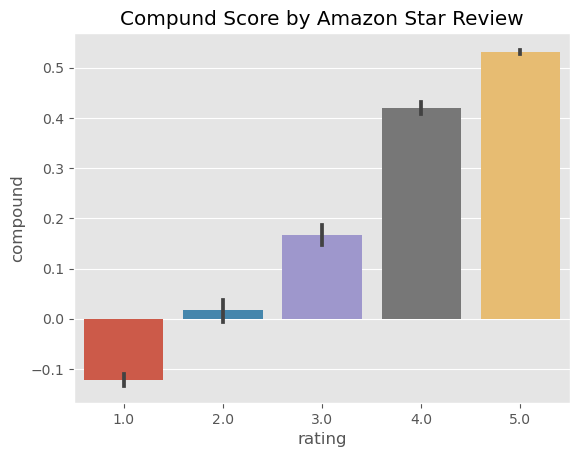

In [26]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

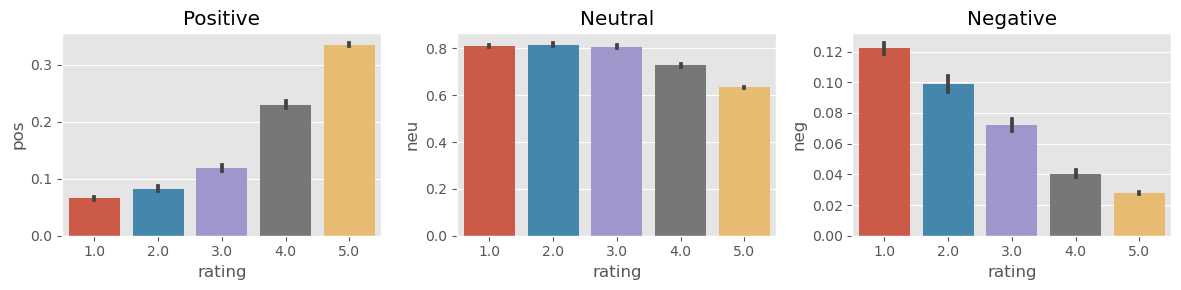

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

next step Install PyTorch

In [28]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [29]:
#pull in a model provided by hugging face pre-trained on a large twitter dataset 
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

c:\Users\gisi_\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [30]:
# Remembering VADER results on example
print(example)
sia.polarity_scores(example)

Easy Replacement Parts for Appliances at a Reduced Price and fits perfect...


{'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'compound': 0.4404}

In [31]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.003501815, 'roberta_neu': 0.095212415, 'roberta_pos': 0.90128577}


In [32]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [33]:
df = Appliance_subset_df.sample(5000)

In [34]:
df.head(2)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
2751,5.0,Fantastic repair kit for the refrigerator,Fantastic repair kit for the refrigerator. El...,[],B00E0CWC6Y,B00E0CWC6Y,AGEDAFM3YKRCMD6W7YDYBRQNV73A,1438555559000,0,True
12727,5.0,Fit magic chef refrigerator freezer,worked perfect,[],B0B6G31123,B0B6G31123,AFXIDZ4MVPMPNP5ZUEMBC75WIRFA,1667584665165,1,True


In [35]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        
        
        text = row['text']
        id = row['user_id']
        vader_result = sia.polarity_scores(text)
        
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[id] = both
    except RuntimeError:
        print(f'Broke for id {id}')

  0%|          | 0/5000 [00:00<?, ?it/s]

Broke for id AG4J7GXLW2XUZ4S6UV6CKVU53U4Q
Broke for id AHF2RFTBKZ7ZE5WMOQEHD454L7CA
Broke for id AFMRJ55YNK57YOIDWEB5MBBMQSWQ
Broke for id AEJVUEDWSKDKCBJZQGWGVWUM46LQ
Broke for id AE72CVOI3H57OQMIFXHKOZTIC7IQ


In [36]:
results_df = pd.DataFrame(res).T
# results_df = results_df.reset_index().rename(columns={'index': 'Id'})


results_df.index.name = 'user_id'
results_df.head(2)

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
user_id,,,,,,,
AGEDAFM3YKRCMD6W7YDYBRQNV73A,0.029,0.845,0.126,0.8754,0.016625,0.098061,0.885314
AFXIDZ4MVPMPNP5ZUEMBC75WIRFA,0.000,0.213,0.787,0.5719,0.037368,0.227885,0.734747


In [37]:
# Reset the index to turn the index into a column
results_df = results_df.reset_index()
results_df.head()

,user_id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
0,AGEDAFM3YKRCMD6W7YDYBRQNV73A,0.029,0.845,0.126,0.8754,0.016625,0.098061,0.885314
1,AFXIDZ4MVPMPNP5ZUEMBC75WIRFA,0.000,0.213,0.787,0.5719,0.037368,0.227885,0.734747
2,AF272EFNTDJN4UTGUNDOCMDILLVQ,0.000,1.000,0.000,0.0000,0.053569,0.836547,0.109884
3,AHJIT253BSZK7LNLVU5ZREVHMWWA,0.000,0.446,0.554,0.7351,0.012361,0.162675,0.824965
4,AF62EUMHE7RTBJMCRKG3K3VZTEYQ,0.172,0.654,0.174,0.0258,0.010059,0.070011,0.919930


## Compare Scores between models

In [39]:
results_df.columns

Index(['user_id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
      dtype='object')

# Step 3. Combine and compare

In [42]:
results_df = results_df.merge(Appliance_subset_df, how='inner')

In [43]:
results_df.head(2)

,user_id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,rating,title,text,images,asin,parent_asin,timestamp,helpful_vote,verified_purchase
0,AGEDAFM3YKRCMD6W7YDYBRQNV73A,0.029,0.845,0.126,0.8754,0.016625,0.098061,0.885314,5.0,Fantastic repair kit for the refrigerator,Fantastic repair kit for the refrigerator. El...,[],B00E0CWC6Y,B00E0CWC6Y,1438555559000,0,True
1,AFXIDZ4MVPMPNP5ZUEMBC75WIRFA,0.000,0.213,0.787,0.5719,0.037368,0.227885,0.734747,5.0,Fit magic chef refrigerator freezer,worked perfect,[],B0B6G31123,B0B6G31123,1667584665165,1,True


In [44]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='rating',
            palette='tab10')
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

In [29]:
# negative sentiment 5-Star view

In [ ]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

In [ ]:
sent_pipeline('I love sentiment analysis!')

In [ ]:
sent_pipeline('Make sure to like and subscribe!')

In [ ]:
sent_pipeline('booo')

# __